# Tarea 2. NN with LMS, Problema 1

## Fundamentos de inteligencia computacional
## por: Juan Pablo Arango A. & Simón Zapata Caro

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pydoc import help  # can type in the python console `help(name of function)` to get the documentation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from IPython.display import display, HTML
from pandas.tools.plotting import scatter_matrix
from matplotlib.artist import setp
import time

plt.rcParams['figure.figsize'] = (10,16)

In [2]:
df1     = pd.io.excel.read_excel("DatosPunto1.xlsx", sheetname=0)
classes = df1.iloc[:,-1].copy()
df1 = df1.iloc[:,0:-2].copy()
df1 = (df1-np.min(df1, axis = 0))/(np.max(df1, axis = 0)-np.min(df1, axis = 0))

y = np.array(classes)
X = np.array(df1)
#random values
i = np.random.permutation(X.shape[0])
X = X[i,:]
y = y[i]

In [3]:
def derivating(fx):
    difcoefs = [1,-1]
    return np.convolve(fx,difcoefs,mode='same')

def LMS_training(X,y,iteraciones=500,alpha=0.001):
    
    ##falta mirar como imprimir Error en tiempo real
    
    w_          = np.random.rand(X.shape[1] + 1,)
    n           = X.shape[0]
    nf          = X.shape[1]
    lim         = 5
    sw          = 0
    j           = 0
    index       = []
    error_array = []
    

    while j < iteraciones and sw == 0:
        for i in range(0,n):
            g  = np.dot(w_,np.insert(X[i,:],0,1).T)
            e  = g - y[i]
            w_ = w_ - alpha*e*np.insert(X[i,:],0,1)
        predicted = []
        for i in range(0,n):
            predicted.append(Predict(X[i,:],w_))
        g = (y-predicted)
        E = 0.5*np.sum(g*g.T)/y.shape #queda la duda
        
        index.append(j)
        error_array.append(E[0])
        d_error_array = derivating(error_array)
        
        if np.abs(d_error_array[len(d_error_array)-1]) < 0.01:
            sw = 1
        
        j = j + 1
    print('error cuadrático medio: '+str(E[0])+', iteraciones: '+str(j))
    plt.plot(index,d_error_array)
    plt.xlabel('Iteraciones')
    plt.ylabel('ECM')
    plt.grid()
    plt.show()
    
    return [w_,predicted]

def Predict(X,w_): 
    return np.dot(w_,np.insert(X,0,1).T)

error cuadrático medio: 5.788865988529075, iteraciones: 33


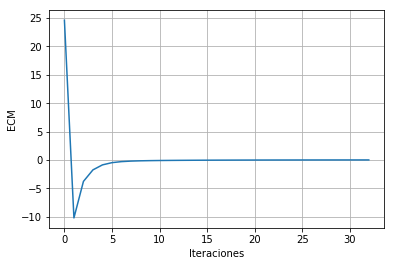

In [4]:
[wLMS,predicted] = LMS_training(X,y,iteraciones=1000)

In [5]:
d = {'datos_predichos': predicted, 'diferencia' : np.abs(predicted-y),'etiquetas': y}
df = pd.DataFrame(data=d)
df

,datos_predichos,diferencia,etiquetas
0,16.734153,0.544153,16.19
1,14.347119,0.627119,13.72
2,16.287903,0.812097,17.10
3,33.513524,2.696476,36.21
4,35.053474,1.173474,33.88
5,12.507742,1.162258,13.67
6,18.685334,0.795334,17.89
7,32.827165,2.627165,30.20
8,15.990088,0.909912,16.90
9,18.541493,0.691493,17.85


In [6]:
max(np.abs(predicted-y))

12.788931399526177